# LMNOP

**LLM-based Microbiome Metadata NOtebook Processing:**  A jupyter notebook tool that integrates calls to ChatGPT for streamlined microbiome metadata cleaning.

*A natural-language approach to metadata investigation and cleaning using the `ChatGPT 4` LLM, the `Langchain` AI framework, and AI-based speech recognition using OpenAI's `whisper` library.*

Metadata associated with microbiome samples contains the information necessary for mapping samples and their microbial profiles to characteristics like the environment from which a sample came, time of collection, numerous clinical parameters that describe a patient from which a sample came in human studies, or geographic information in ecology studies. They are thus one of the most important data layers in microbiome data analysis. Metadata is frequently collected by hand and is thus prone to human errors such as misspellings or the addition of trailing white spaces, all of which would lead to erroneous conclusions from metagenomic data. Despite the importance of integral metadata, proper attention to data cleaning is frequently overlooked for two key reasons. First, metadata contains many fields for many samples, making it impossible to inspect by hand, especially with the growing scale of metagenomic studies. Second, comprehensive tools do not exist to thoroughly inspect metadata in the same way that they do for the sequencing data itself. Recent advancements in AI have enabled Large Language Models to perform tasks like parsing and analyzing large bodies of text, however to the best of our knowledge, this technology has not been applied in the space of microbiome metadata validation. Here we present **LMNOP (LLLM-based Microbiome metadata NOtebook Processing)**, a tool for inspecting and correcting common human errors found in microbiome metadata. **LMNOP** integrates calls to ChatGPT into a Jupyter Notebook for streamlined generation of code to clean and manipulate metadata files. It also provides functionality to summarize and visualize all fields in a manner that makes constructing clinical attribute tables in human microbiome studies much simpler by providing summary statistics. Measures in the notebook are taken to ensure the reproducibility of stochastic calls to an LLM. Voice recognition is also supported using whisper, OpenAI’s extremely accurate speech transcription function.

## Adjustable LLM settings

Note that you *should not* replace "OPENAI_API_KEY" with your actual API key. This variable is set to later assert that in your environment, there exists an environment variable called OPENAI_API_KEY.

In [1]:
g_GEMINI = "GOOGLE_API_KEY"
g_CHATGPT = "OPENAI_API_KEY"

g_chosen_llm = g_CHATGPT

### Speech recognition
If you wish to disable speech recognition, set the following to `False`. Speech recognition is available through activating button widgets, how to do so will be covered later in this tutorial. Disabling speech recognition will remove the voice recording buttons from the buttons widgets.

In [2]:
g_use_speech = True

### Message History

- **WARNING:** Increasing this number will increase the amount of information included in each LLM query and thus increase the cost of the queries
- Decreasing this number will make the LLM forget past exchanges more quickly

In [3]:
g_num_msgs_in_history = 4

In [4]:
g_base_prompt = f"using pandas 3 and python 3.10+ to clean data in jupyter lab."
g_ds_prompt = f"You are a data scientist {g_base_prompt}"
g_pf_prompt = f"You are a professor of data science teaching a class on {g_base_prompt}." 

## Imports

In [5]:
import pandas as pd
import numpy as np
import re
import os

In [6]:
import ipywidgets as widgets
from IPython import get_ipython
from IPython.display import display
from threading import Thread
from traitlets import observe, link, Unicode, Bool, Any
from ipylab import JupyterFrontEnd
import time
import functools

In [7]:
import sounddevice as sd
from scipy.io.wavfile import write
import tempfile
from openai import OpenAI

In [8]:
import speech_recognition as speech_recog

In [9]:
from langchain_core.messages import trim_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

In [10]:
import warnings

In [11]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.WARNING, format='%(levelname)s: %(message)s')

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Model creation

In [13]:
assert g_chosen_llm in os.environ, f"Please set the {g_chosen_llm} environment variable."

In [14]:
if g_chosen_llm == g_CHATGPT:
    from langchain_openai import ChatOpenAI
    _g_chat_model = ChatOpenAI(model="gpt-4o-mini")
elif g_chosen_llm == g_GEMINI:
    from langchain_google_genai import ChatGoogleGenerativeAI
    _g_chat_model = ChatGoogleGenerativeAI(
        model="gemini-1.5-pro",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
    )
else:
    raise ValueError(f"Unrecognized llm model '{g_chosen_llm}'")

## Chat creation

In [15]:
def _start_chat(model, custom_prompt):  
    """ Define trimmer. Count each message as 1 "token" (token_counter=len) and 
        keep only the last x messages.
    """
    trimmer = trim_messages(strategy="last", max_tokens=g_num_msgs_in_history, 
                            token_counter=len)
    
    workflow = StateGraph(state_schema=MessagesState)
    
    # Define the function that calls the model
    def call_model(state: MessagesState):
        trimmed_messages = trimmer.invoke(state["messages"])
        system_prompt = custom_prompt
        messages = [SystemMessage(content=system_prompt)] + trimmed_messages
        response = model.invoke(messages)
        return {"messages": response}
    
    
    # Define the node and edge
    workflow.add_node("model", call_model)
    workflow.add_edge(START, "model")
    
    # Add simple in-memory checkpointer
    memory = MemorySaver()
    app = workflow.compile(checkpointer=memory)
    return app

In [16]:
_g_chat = _start_chat(_g_chat_model, g_ds_prompt)

## Prompt engineering

In [17]:
# ai helper prompts
g_unique_set_prefix = "for column named"
g_col_check_prefix = "check column named"
g_code_prefix = "write code to"

# function helper prompts
g_summarize_statement = "summarize table"
g_summarize_col_statement = "summarize column named"
g_explore_col_statement = "explore column named"

# button prompts
g_add_cell_statement = "add cell"
g_copy_last_statement = "now copy the suggestion"
g_run_last_statement = "now run the suggestion"
g_revert_df_statement = "revert the data frame"

In [18]:
def _remove_known_str(a_prompt, known_str):
    return a_prompt.replace(known_str, "").strip()


def _change_first_char(a_str, upper=True):
    if upper:
        a_lambda = lambda x: x.groups()[0].upper()
    else:
        a_lambda = lambda x: x.groups()[0].lower()
        
    # affect ONLY first letter, leave all the rest alone
    # (so different that a_str.capitialize() or a_str.title())
    return re.sub('([a-zA-Z])', a_lambda, a_str, count=1)   


def _expand_prompt(user_prompt, df_name, a_df):
    """ Prompt engineering that provides context based on the
        loaded metadata file to the LLM.
    """

    df_prompt = f"You are given the '{df_name}' dataframe with columns {list(a_df.columns)}. "

    # end if starts with check prefix--which itself adds a unique set prefix
    if user_prompt.startswith(g_col_check_prefix):
        col_name = _remove_known_str(user_prompt, g_col_check_prefix)
        col_name = col_name.replace(" ", "_")
        user_prompt = _get_explore_col_prompt(col_name)  
        # user_prompt will now start with g_unique_set_prefix
    
    if user_prompt.startswith(g_unique_set_prefix):
        new_prompt = _get_unique_set_prompt(user_prompt, a_df)
    elif user_prompt.startswith(g_code_prefix):
        new_prompt = _get_code_prompt(user_prompt)        
    else:
        new_prompt = user_prompt

    new_prompt = df_prompt + new_prompt

    return new_prompt


def _get_explore_col_prompt(col_name):
    
    explore_prompt = (
        "Suggest the appropriate Pandas data type for the values in this column, "
        "say 'Column is thought to be xxx' where xxx is either identifier, categorical, or numeric. "
        "Do not format. "
        "Very briefly hypothesize about what they represent, and indicate if any "
        "look invalid or unexpected."
    )
    
    col_prompt = f"{g_unique_set_prefix} {col_name}, {explore_prompt}"
    return col_prompt


def _get_unique_set_prompt(user_prompt, a_df):
    """ Extends 'for column named x,' in a question to
        provide context: the unique values of that column.
        Then asks the question, whatever is present after the comma.
    """
    err_msg = f"Please phrase your question as {g_unique_set_prefix} <col_name>, <question about unique values of column>"
    if not user_prompt.startswith(g_unique_set_prefix):
        return err_msg

    # Split the prompt by a comma
    prompt_split = user_prompt.split(",") 
    if len(prompt_split) < 2:
        return err_msg

    col_name = prompt_split[0].replace(g_unique_set_prefix, "").strip()
    new_prompt = f"For the column named '{col_name}' containing the set of values  {set(a_df[col_name])}, {','.join(prompt_split[1:])}"
    return new_prompt


def _get_code_prompt(user_prompt):
    err_msg = f"Please phrase your question as {g_code_prefix} <perform some operation>"
    
    if not user_prompt.startswith(g_code_prefix):
        return err_msg

    new_prompt = f"{user_prompt} Do not include any non-comment explanations, import statements, or the instantiation of the dataframe. Do not include markdown formatting in your output. Provide runnable code as output."
    return new_prompt

## State management

In [19]:
_g_last_code_out = {}
_g_last_working_df = {}

In [20]:
_g_LAST_CODE_NAME = "AI-generated code"
_g_LAST_DF_NAME = "g_working_df"   

def _get_df_name(df_name):
    return df_name if df_name is not None else _g_LAST_DF_NAME


def _get_df(a_df):
    return a_df if a_df is not None else g_working_df


def _save_state(state_dict, obj_to_save, state_name, use_last_execution_num=False):
    # this does NOT copy the input obj_to_save before saving it--that should happen outside this call, if needed
    execution_num = get_ipython().execution_count
    if use_last_execution_num:
        execution_num = execution_num - 1
    
    if execution_num in state_dict:
        warnings.warn(f"{state_name} already contains state for a cell with execution number {execution_num}, which will be overwritten.")
    state_dict[execution_num] = obj_to_save
    return state_dict


def _get_last_state(state_dict):
    last_value = None
    if state_dict is not None and len(state_dict)>0:
        last_key, last_value = next(reversed(state_dict.items()))
    return last_value


def _df_changed():

    last_working_df = _get_last_state(_g_last_working_df)

    if last_working_df is not None:
        if not last_working_df.equals(g_working_df):
            return True
    return False


def _revert_df():
    global g_working_df
    msg = f"'There is no {_g_LAST_DF_NAME} state stored.'" 

    last_working_df = _get_last_state(_g_last_working_df)
    if last_working_df is not None:
        if _df_changed():
            store_working_df()
            g_working_df = last_working_df
            msg = f"{_g_LAST_DF_NAME} reverted to last saved state."
        else:
            msg = f"{_g_LAST_DF_NAME} has not changed since last saved state."
    return msg


def store_working_df(a_df=None, use_last_execution_num=False):
    if a_df is None:
        a_df = g_working_df.copy()
    _save_state(_g_last_working_df, a_df, _g_LAST_DF_NAME, use_last_execution_num=use_last_execution_num)


def revert_df():
    statement = _revert_df()
    return statement


def stateful(func):
    """ Decorator function for storing working df. """

    def wrapper(*args, **kwargs):
        if _df_changed():
            store_working_df(use_last_execution_num=True)
        func(*args, **kwargs)
    return wrapper

## Front-end helpers

In [21]:
_g_front_end = JupyterFrontEnd()

In [22]:
def _set_raw():
    _g_front_end.commands.execute('notebook:change-cell-to-raw')

def _move_cursor_up():
    _g_front_end.commands.execute('notebook:move-cursor-up')

def _insert_and_populate(statement=None, move_up=True):
    _g_front_end.commands.execute('notebook:insert-cell-below')
    if statement is not None:
        time.sleep(0.2)
        _g_front_end.commands.execute('notebook:replace-selection', { 'text': statement})
        _g_front_end.commands.execute('notebook:enter-edit-mode')

    if move_up:
        _g_front_end.commands.execute('notebook:move-cell-up') 
        

def _insert_and_run(statement=None, move_up=True):
    _insert_and_populate(statement, move_up)
    
    if statement is not None:
        _g_front_end.commands.execute('notebook:run-cell-and-select-next')  
        _g_front_end.commands.execute('notebook:enter-edit-mode')


def _set_query_to_raw(up_twice=False):
    # move the cursor up to the query cell (the one running right now)
    # and set *it* to raw
    _g_front_end.commands.execute('notebook:move-cursor-up')
    if up_twice:
        _g_front_end.commands.execute('notebook:move-cursor-up')
    _set_raw()

    # move the cursor down TWICE: once from the query cell to the
    # cell holding its output (either a raw cell or a created code cell), 
    # and once more to whatever comes next
    _g_front_end.commands.execute('notebook:move-cursor-down')
    _g_front_end.commands.execute('notebook:move-cursor-down')    


def _set_query_and_output_to_raw(output):
    # creates a (code) cell containing the (non-code) output;
    # cursor is now on that new cell
    _insert_and_populate(output)

    # change now-current (new) cell to raw format
    _set_raw()
    _set_query_to_raw()


def _set_query_to_raw_and_run_code_cell(code_str):

    _save_state(_g_last_code_out, code_str, _g_LAST_CODE_NAME)
    _insert_and_run(code_str, move_up=True)
    _set_query_to_raw(up_twice=True)  

## Chat helper function creation

In [23]:
# Instantiating an empty notebook allows prompt methods to bind to the 
# variable so the can use the real contents later without needing to be 
# passed an argument
g_working_df = pd.DataFrame()

In [24]:
@stateful
def find_problem_headers(a_df=None):
    """ Find all headers which include anything except a-z A-Z0-9 . _  characters.
        No returns only prints headers.

        a_df (DataFrame): Default None which gets cast to g_working_df.
    """
    a_df = _get_df(a_df)

    invalid_cols = a_df.columns[a_df.columns.str.contains(r'[^a-zA-Z0-9._ ]', regex=True)]
    if len(invalid_cols) == 0:
        out = "No invalid column headers found."
    else:
        out = invalid_cols
    print(out)


@stateful
def scrub_headers(a_df=None, lcase_headers=True):
    """ Scrub all headers which include anything except a-z A-Z0-9 . _  characters.
        No returns only prints headers.

        a_df (DataFrame): Default None which gets cast to g_working_df.
        lcase_headers (bool): Default True. Cast headers to lower case?
    """
    
    a_df = _get_df(a_df)

    a_df.columns = a_df.columns.str.replace(r'[^a-zA-Z0-9]', '_', regex=True)  
    a_df.columns = a_df.columns.str.replace(r'__+', '_', regex=True)  
    a_df.columns = a_df.columns.str.strip('_')

    if lcase_headers:
        a_df.columns = a_df.columns.str.lower()
    print(a_df.columns)


@stateful
def find_problem_records(a_df=None):
    """ Identify problem records as records with any 
        leading or trailing spaces in any field.
        Either returns problem records as a data frame or 
        prints a message: No problem records found.

        a_df (DataFrame): Default None which gets cast to g_working_df.
    """
    
    a_df = _get_df(a_df)

    # get records with leading or trailing spaces in any field
    fn = lambda x: x.str.contains(r'^\s|\s$', na=False).any()
    problems = a_df[a_df.apply(fn, axis=1)]
    if len(problems) == 0:
        print("No problem records found.")
    else:
        problems = problems.loc[:,problems.apply(fn, axis=0)]
        display(problems)
        return problems


@stateful
def scrub_problem_records():
    """ Remove trailing spaces in found problem records.
    
        Prints: "Problem records scrubbed."
        and will automatically modify g_working_df.
    """
    global g_working_df
    
    # Remove leading or trailing spaces from any field in the dataframe
    g_working_df = g_working_df.map(lambda x: x.strip() if isinstance(x, str) else x)
    print("Problem records scrubbed.")


def _stats_from_col(col_name, col_type_names, a_df, visualize):

    type_of = col_type_names[col_name]

    stats = []  # List of lines
    plot = None
    
    if type_of == 'categorical':
        stats += categorical_stats(col_name, a_df)
        if visualize:
            plot = visualize_col_categorical(col_name, a_df)

    elif type_of == 'numeric':
        stats += numeric_stats(col_name, a_df)
        if visualize:
            plot = visualize_col_numeric(col_name, a_df)
        
    elif type_of == 'identifier':
        stats += id_stats(col_name, a_df)

    stats.append('\n')
    
    return stats, plot


In [25]:
def _ask(user_prompt, df_name=None, a_df=None):
    df_name = _get_df_name(df_name)
    a_df = _get_df(a_df)
    
    new_prompt = _expand_prompt(user_prompt, df_name, a_df)    
    result = _g_chat.invoke(
        {"messages": [HumanMessage(content=new_prompt)]},
        config={"configurable": {"thread_id": "1"}},
    )
    return new_prompt, result

def _get_result_text(a_result):
    return a_result.get("messages")[-1].content


def _clean_answer(answer_str):
    answer_str = re.sub("^```python\n", "", answer_str)
    answer_str = re.sub("\n```$", "", answer_str)   
    return answer_str
    

def _get_ask_txt(ask_result):  
    output = _get_result_text(ask_result)
    output = _clean_answer(output) 
    return output

In [26]:
_id_type = 'identifier'
_cat_type = 'categorical'
_num_type = 'numeric'

def _ai_get_col_type_one(col_name, a_df=None, df_name=None):

    a_df = _get_df(a_df)
    df_name = _get_df_name(df_name)
    
    col = a_df[col_name].unique()
    _, result = _ask(
        f'based on the following entries: {col}, in a column named {col_name} '
        f'should the data be categorical or numeric or identifier. '
        f'Give a one word answer either categorical or numeric or identifier.',
        df_name=df_name, a_df=a_df)

    t = _get_result_text(result)

    col_type = _id_type
    for poss_type in [_num_type, _cat_type]:
    	if poss_type in t.lower():
    		col_type = poss_type
    		break

    return col_type


def _ai_get_col_types(df_name, a_df, col_names_list=None):

    df_name = _get_df_name(df_name)
    a_df = _get_df(a_df)
    col_types = {}

    for col_name in a_df.columns:

        col_type = _ai_get_col_type_one(col_name, a_df=a_df, df_name=df_name)
        col_types[col_name] = col_type

    return col_types

## Summarize

In [27]:
def _get_coltypes_str(col_types, col_names_list=None):
    if col_names_list == None:
        col_names_list = list(col_types.keys())
        
    min_col_types = {k: v for k, v in col_types.items() if k in col_names_list}
    min_coltypes_str = "{" + ", ".join(f'"{key}": "{value}"' for key, value 
                                   in min_col_types.items()) + "}"
    return min_coltypes_str


def _get_ai_coltypes_str(df_name, a_df, col_names_list=None):
    col_types = _ai_get_col_types(df_name, a_df, col_names_list)
    coltypes_str = _get_coltypes_str(col_types, col_names_list)
    return coltypes_str


def _ai_summarize_col(col_name, df_name, a_df, max_items_shown=None, visualize=True):
    one_coltypes_str = _get_ai_coltypes_str(df_name, a_df, col_names_list=[col_name])
    result = f"summarize_col('{col_name}', {one_coltypes_str}, df_name='{df_name}', a_df={df_name}, max_items_shown={max_items_shown}, visualize={visualize})"
    _set_query_to_raw_and_run_code_cell(result)


def _ai_summarize(df_name, a_df, max_items_shown=None, visualize=False):
    coltypes_str = _get_ai_coltypes_str(df_name, a_df)
    print(coltypes_str)
    result = f"summarize(col_types={coltypes_str}, df_name='{df_name}', a_df={df_name}, max_items_shown={max_items_shown})"
    print(result)
    _set_query_to_raw_and_run_code_cell(result)


def _deterministic_summarize_col(col_name, col_type_names, a_df=None, max_items_shown=None, visualize=True):
    a_df = _get_df(a_df)
    max_items_shown = max_items_shown if max_items_shown is not None else 10
    
    lines = []
    lines.append(f"{col_name}")
    lines.append("================")
    a_col = a_df[col_name]
    
    summary = []
    col_uniques = a_col.unique()
    count_uniques = len(col_uniques)
    if a_col.is_unique:
        summary.append(f"All {count_uniques} values are unique.")
    else: 
        summary.append(f"There are {count_uniques} unique value(s) in {len(a_col)} total values.")
    # end if all are unique
        
    caveat = f"first {max_items_shown} " if count_uniques > max_items_shown else ""
    summary.append(f"The {caveat}unique value(s):{col_uniques[:max_items_shown]}.")
    lines.append(" ".join(summary))
    lines.append(f"The current dataframe datatype is {a_col.dtype}.")

    stats, plot = _stats_from_col(col_name, col_type_names, a_df, visualize)
    lines.extend(stats)

    if not visualize:
        plot = None
    return lines, plot
    

def _validate_column(col_name, a_df, df_name):
    if col_name not in a_df.columns:
        raise ValueError(f'Column {col_name} not found in {df_name}')

@stateful
def summarize_col(col_name, col_types=None, df_name=None, a_df=None, max_items_shown=None, visualize=True):
    """ Summarizes a single column.
    
        col_name (str): name of column in a_df to summarize
        col_types (dict): default None, gets populated by a call to the llm,
            type of column being summarized. Ex. {'year_of_birth': 'numeric'}
        df_name (str): default None which is cast to 'g_working_df'
        a_df (DataFrame): default None which is cast to g_working_df
        max_items_shown (int): default None which is cast to 10.
            Number of unique values in a column to display
        visualize (bool): default True. Display plot?
    """

    df_name = _get_df_name(df_name)
    a_df = _get_df(a_df)
    
    _validate_column(col_name, a_df, df_name)
    
    if col_types is None:
        _ai_summarize_col(col_name, df_name, a_df, max_items_shown, visualize=visualize)
    else:
        result, plot = _deterministic_summarize_col(col_name, col_types, a_df, max_items_shown, visualize=visualize)
        result_str = "\n".join(result)
        print(result_str)
        if visualize:
            plt.show()


@stateful
def summarize(df_name=None, a_df=None, col_types=None, max_items_shown=None):
    """ Summarize all columns in a data frame. No required arguments. """
    
    df_name = _get_df_name(df_name)
    a_df = _get_df(a_df)
    print(f'Summarizing {df_name}...\n')

    result = [f"The dataframe '{df_name}' has {len(a_df)} rows and {len(a_df.columns)} columns.", " "]
    if col_types is None:
        # This ai method will find col_types then call summarize()
        _ai_summarize(df_name, a_df, max_items_shown, visualize=False)
        
    else:
        # When call is made passing inferred col_types
        for curr_col_name in a_df.columns:
            
            curr_result, plot = _deterministic_summarize_col(
                curr_col_name, col_types, a_df, max_items_shown, 
                visualize=False)
            
            result.extend(curr_result)
            # next column
            result_str = "\n".join(result)
            print(result_str)
            if plt.get_fignums():
                plt.clf()
            result = []

## Stats

In [28]:
def categorical_stats(col_name, a_df):
    """ Returns list of printable lines.
        Stat summary for categorical column.
    """

    col = a_df[col_name]
    counts = col.value_counts().to_string()

    # Report column type as CATEGORICAL
    lines = []
    lines.append(f'Column {col_name} thought to be categorical.')
    lines.append('------ Summary Statistics ------')
    lines.append(counts+'\n')
    
    return lines


def numeric_stats(col_name, a_df):
    """ Returns list of printable lines.
        Stat summary for numeric column.
    """

    # Drop nan values, coerce to numeric, then drop nans again
    col = a_df[col_name]
    new_col = pd.to_numeric(col.dropna(), errors='coerce')
    new_col = new_col.dropna()
    
    MIN = min(new_col)
    MAX = max(new_col)
    MED = np.median(new_col)

    # Report column type as NUMERIC
    lines = []
    lines.append(f'Column {col_name} thought to be numeric.')
    lines.append('------ Summary Statistics ------')
    lines.append(f'min: {MIN}\nmax: {MAX}\nmedian: {MED}\n')
    
    return lines

def id_stats(col_name, a_df):
    """ Returns list of one printable line for id column. """

    # Report column type as IDENTIFIER
    lines = [f'Column {col_name} thought to be identifier.\n']
    return lines
    

## Visualizations

In [29]:
def visualize_col_categorical(col_name, df_name=None, a_df=None):
    """
    Generates a bar plot for the value counts of a specified column.

    Parameters:
        col_name (str): The column to group by.
        df_name (DataFrame): Name of dataframe if different than g_working_df.
        a_df (DataFrame): Dataframe if different than g_working_df
    """

    a_df = _get_df(a_df)
    df_name = _get_df_name(df_name)

    fig, ax = plt.subplots()

    col_counts = a_df[col_name].value_counts()
    sns.barplot(x=col_counts.index, 
                y=col_counts.values,
                ax=ax)
    ax.set_title(f"Value Counts for {col_name}")
    ax.set_ylabel("Counts")
    ax.set_xlabel(col_name)
    ax.tick_params(axis='x', rotation=45)  # Method 2: Directly rotate ticks

    return fig

def visualize_col_numeric(col_name, df_name=None, a_df=None):
    """
    Generates a histogram of a specified column.

    Parameters:
        col_name (str): The column to group by.
        df_name (DataFrame): Name of dataframe if different than g_working_df.
        a_df (DataFrame): Dataframe if different than g_working_df
    """

    a_df = _get_df(a_df)
    df_name = _get_df_name(df_name)

    warnings.filterwarnings('ignore')
    df = a_df[[col_name]]
    df[col_name] = pd.to_numeric(df[col_name], errors='coerce')

    df = df.dropna()
    fig, ax = plt.subplots()
    sns.kdeplot(
       data=df, x=col_name,
       fill=True, common_norm=False,
       alpha=.5, linewidth=0, ax=ax
    )
    ax.set_title(f'{col_name}')
    return fig


def visualize_col(col_name, col_types=None, df_name=None, a_df=None):

    a_df = _get_df(a_df)
    df_name = _get_df_name(df_name)

    _validate_column(col_name, a_df, df_name)

    if col_types == None:
        type_of =  _ai_get_col_type_one(col_name, a_df, df_name)
    else:
        type_of = col_types[col_name]

    if type_of == _cat_type:
        ax = visualize_col_categorical(col_name, a_df)
        plt.show()

    if type_of == _num_type:
        ax = visualize_col_numeric(col_name, a_df)
        plt.show()

    if type_of == _id_type:
        print(id_stats(col_name, a_df)[0])

def visualize_two_cols_cc(col_name1, col_name2, df_name=None, a_df=None):
    """
    Generates a stacked bar plot of the different values colored by category.
    """
    
    a_df = _get_df(a_df)
    df_name = _get_df_name(df_name)

    counts = a_df.groupby([col_name1, col_name2]).size().unstack(fill_value=0)
    fig, ax = plt.subplots()
    counts.plot(kind='bar', stacked=True, ax=ax)
    ax.set_xlabel(col_name1)
    ax.set_ylabel('Number of Observations')
    ax.set_title(f'Observations by {col_name1} and {col_name2}')
    ax.tick_params(axis='x', rotation=45)
    return fig


def visualize_two_cols_cn(cat_col, num_col, df_name=None, a_df=None):
    """
    Generates a histogram plot of the different values colored by category.
    """
    
    a_df = _get_df(a_df)
    df_name = _get_df_name(df_name)

    # Drop nan values, coerce to numeric, then drop nans again
    df = a_df[[num_col, cat_col]]
    df = df.dropna()
    df[num_col] = pd.to_numeric(df[num_col], errors='coerce')
    df[cat_col] = df[cat_col].astype('category')
    df = df.dropna()

    fig, ax = plt.subplots()
    sns.kdeplot(
        data=df, x=num_col, hue=cat_col,
        fill=True, common_norm=False,
        alpha=.5, linewidth=0, ax=ax,
        warn_singular=False  # Dataset has 0 variance - skip warning
    )
    
    ax.set_title(f'{num_col} by {cat_col}')
    return fig


def visualize_two_cols_nn(col_name1, col_name2, df_name=None, a_df=None):
    """
    Generates a line plot of the two numeric columns plotted.
    """
    
    a_df = _get_df(a_df)
    df_name = _get_df_name(df_name)

    # Drop nan values, coerce to numeric, then drop nans again
    df = a_df[[col_name1, col_name2]]
    df = df.dropna()
    df[col_name1] = pd.to_numeric(df[col_name1], errors='coerce')
    df[col_name2] = pd.to_numeric(df[col_name2], errors='coerce')
    df = df.dropna()

    fig, ax = plt.subplots()
    sns.scatterplot(
        data=df,
        x=col_name1,
        y=col_name2,
        ax=ax
    )
    ax.set_title(f'{col_name1} by {col_name2}')
    return fig


def visualize_two_cols(col_name1, col_name2, col_types=None, df_name=None, a_df=None):
    """
    Generates a plot for two columns.

    col_name1 (str): The first column to group by.
    col_name2 (str): The second column to group by.
    col_types (dict): col_types of at least the two columns
    df_name (str): Name of dataframe if different than g_working_df.
    a_df (DataFrame): Dataframe if differnet than g_working_df.
    """

    a_df = _get_df(a_df)
    df_name = _get_df_name(df_name)

    _validate_column(col_name1, a_df, df_name)
    _validate_column(col_name1, a_df, df_name)

    if col_types == None:
        type_of1 = _ai_get_col_type_one(col_name1, a_df=a_df, df_name=df_name)
        type_of2 = _ai_get_col_type_one(col_name2, a_df=a_df, df_name=df_name)
    else:
        type_of1 = col_types[col_name1]
        type_of2 = col_types[col_name2]
    print(f'Column {col_name1} thought to be {type_of1}.\nColumn {col_name2} thought to be {type_of2}.')

    if type_of1 == _cat_type and type_of2 == _cat_type:
        visualize_two_cols_cc(col_name1, col_name2, a_df)
    elif type_of1 == _cat_type and type_of2 == _num_type:
        visualize_two_cols_cn(col_name1, col_name2, a_df)
    elif type_of1 == _num_type and type_of2 == _cat_type:
        visualize_two_cols_cn(col_name2, col_name1, a_df)
    elif type_of1 == _num_type and type_of2 == _num_type:
        visualize_two_cols_nn(col_name1, col_name2, a_df)
    else:
        print('Invalid column types.')

## Explore and Run

In [30]:
def _explore_col(col_name, df_name=None, a_df=None):
    full_prompt = _get_explore_col_prompt(col_name)
    return _ask(full_prompt, df_name, a_df)


def _find_cat(text):
    """ Regular expression to find the pattern and capture the inferred type. """
    
    match = re.search(r'Column is thought to be (identifier|categorical|numerical)', text)
    if match:
        # result contains only the word 'identifier', 'categorical', 'numerical'
        result = match.group(1)  
    return result


@stateful
def explore_col(col_name, df_name=None, a_df=None):
    """ Get summary statistics from a column and theorize about meaning of values. 

        col_name (str): name of column
        df_name (str): Default None which gets cast to 'g_working_df'
        a_df (DataFrame): Default None which gets cast to g_working_df 
    """

    df_name = _get_df_name(df_name)
    a_df = _get_df(a_df)
    _validate_column(col_name, a_df, df_name)


    _, result = _explore_col(col_name, df_name, a_df)
    result_txt = _get_result_text(result)

    col_type = _find_cat(result_txt)
    stats, plot =  _stats_from_col(col_name, {col_name: col_type}, a_df, visualize=False)

    output = [result_txt]
    output.extend(stats)
    print(output)
    output = '\n'.join(output)
    output = output.strip()
    
    _set_query_and_output_to_raw(output)

    
def _run_predefined_prompts(user_prompt):
    unrecognized = False
    
    # Note, this is a full prompt, a not prompt prefix, or
    # else we might erroneously catch the user trying to 
    # start a request for something else
    if user_prompt == g_summarize_statement:
        summarize()
    elif user_prompt.startswith(g_summarize_col_statement):
        col_name = _remove_known_str(user_prompt, g_summarize_col_statement)
        summarize_col(col_name)
    elif user_prompt.startswith(g_explore_col_statement):
        col_name = _remove_known_str(user_prompt, g_explore_col_statement)
        explore_col(col_name)        
    else:
        unrecognized = True
    return unrecognized
    

@stateful
def ask(user_prompt, df_name=None, a_df=None, show_prompt=False):  
    orig_prompt = user_prompt

    try:
        user_prompt = _change_first_char(user_prompt, upper=False)
        unrecognized = _run_predefined_prompts(user_prompt)
    
        if unrecognized:
            # otherwise, ask AI
            prompt, result = _ask(user_prompt, df_name, a_df)  
            output = _get_ask_txt(result)

            if show_prompt:
                output = prompt + "\n\n" + output

            _save_state(_g_last_code_out, output, _g_LAST_CODE_NAME)
            _set_query_and_output_to_raw(output)
    finally:
        pass

## Widget creation
Widget creation informed by [this github issue comment](https://github.com/jupyter-widgets/ipywidgets/issues/2962#issuecomment-724210454).

In [31]:
class ConfirmationButton(widgets.HBox):
    button_style = Any(default_value='')
    description = Unicode()
    disabled = Bool()
    icon = Unicode()
    layout = Any()
    style = Any()
    tooltip = Unicode()
    
    def  __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._button = widgets.Button(**kwargs)
        self._confirm_btn = widgets.Button(description='Confirm', icon='check', 
                                           button_style='success', layout=dict(width='auto'))
        self._cancel_btn = widgets.Button(description='Cancel', icon='times', 
                                          button_style='warning', layout=dict(width='auto'))
        self._button.on_click(self._on_btn_click)
        self._cancel_btn.on_click(self._on_btn_click)
        self._confirm_btn.on_click(self._on_btn_click)
        self.children = [self._button]
        for key in self._button.keys:
            if key[0]!='_':
                link((self._button,key), (self, key))
        
    def on_click(self, *args, **kwargs):
        self._confirm_btn.on_click(*args, **kwargs)
        
    def _on_btn_click(self, b):
        if b==self._button:
            self.children = [self._confirm_btn, self._cancel_btn]
        else:
            self.children = [self._button]

In [32]:
def _add_cell(a_button=None):
    _insert_and_run(None, move_up=True)
    
def _revert_df_from_button(a_button=None, move_up=True):
    statement = "revert_df()"
    _insert_and_run(statement, move_up=move_up) 


def _run_suggestion_from_button(a_button=None, move_up=True):
    statement = "run_suggestion()"
    _insert_and_run(statement, move_up=move_up)

def _copy_or_run_suggestion(a_button, move_up, copy_only=True):
    statement = _get_last_state(_g_last_code_out)
    if not statement:
        statement = f'There is no {_g_LAST_CODE_NAME} stored.' 
        _insert_and_populate(statement, move_up=move_up)
        _set_raw()
    else:
        if copy_only:
            _insert_and_populate(statement, move_up=move_up)
        else:
            _insert_and_run(statement, move_up=move_up)  

@stateful
def copy_suggestion(a_button=None, move_up=True):
    _copy_or_run_suggestion(a_button, move_up, copy_only=True)
    _set_query_to_raw(up_twice=False)


@stateful
def run_suggestion(a_button=None, move_up=True):
    _copy_or_run_suggestion(a_button, move_up, copy_only=False)
    _set_query_to_raw(up_twice=True)


def _preview(a_button):
    statement = "g_working_df.head()"
    _insert_and_run(statement, move_up=True)


def preview(a_df=None, df_name=None):
    a_df = _get_df(a_df)
    display(a_df.head())


In [33]:
def _add_first_button(a_widget, a_button):
    curr_buttons = list(a_widget.children)
    curr_buttons.insert(0, a_button)
    return tuple(curr_buttons)  

In [34]:

_g_preview_button = widgets.Button(
    description="Preview df",
    button_style="primary",  # full blue
    tooltip="Show header of data frame",
    icon="eye"
)
_g_preview_button.on_click(_preview)

_g_add_cell_button = widgets.Button(
    description="Add Cell",
    button_style="primary",  # full blue
    tooltip="Add an empty code cell",
    icon="plus"
)
_g_add_cell_button.on_click(_add_cell)


_g_copy_suggestion_button = widgets.Button(
    description="Copy Suggestion",
    tooltip="Copy AI-generated code to a new cell",
    icon="copy"
)
_g_copy_suggestion_button.style.button_color = 'lightgreen'
_g_copy_suggestion_button.on_click(copy_suggestion)


_g_run_suggestion_button = widgets.Button(
    description="Run Suggestion",
    button_style="info",  # light blue
    tooltip="Run last AI-generated code in a new cell",
    icon="run"
)
_g_run_suggestion_button.on_click(_run_suggestion_from_button)

_g_undo_button = ConfirmationButton(
    description='Revert Df', 
    tooltip="Revert dataframe to last stored state",
    button_style="warning"  # red
)
_g_undo_button.on_click(_revert_df_from_button)


g_buttons = widgets.HBox([_g_add_cell_button, _g_copy_suggestion_button, _g_run_suggestion_button, _g_undo_button, _g_preview_button])

## Voice Audio recognition

Record audio button was originally lifted from [this youtube resource](#https://youtu.be/2kSPbH4jWME) but has since been updated. If `g_use_speech=True` is set at the beginning of this notebook, a speech button will be added to the button widgets for recording.

In [35]:
def _record_audio(duration, sample_rate, channels):
    """ Record audio from the microphone for <duration> seconds.
        The sampling rate is how frequently the model picks up sound.
        The channel is based on the internal microphone. 
        
        Parameters:
        duration (int): numer of seconds to record 
        sample_rate: The sampling frequency in Hertz (frames per second)
        https://python-sounddevice.readthedocs.io/en/0.5.1/api/
        streams.html#sounddevice.InputStream
        https://www.izotope.com/en/learn/digital-audio-basics-sample-
        rate-and-bit-depth.html#:~:text=While%20using%20high%20sample%20rates,
        interface%20will%20yield%20excellent%20results.
        channels (int): number of channels to report audio to
    """
    audio = sd.rec(
        int(duration * sample_rate), 
        samplerate=sample_rate, 
        channels=channels, 
        dtype='float32'
    )
    sd.wait() 
    audio = _validate_audio(audio, sample_rate)
    audio_normalized = np.int16(audio / np.max(np.abs(audio)) * 32767)
    return audio_normalized

def _validate_audio(audio, sample_rate, threshold=200):
    """ Ensure that the sum of the magnitude of the recording exceeds the threshold. """

    audio_arr = audio[:, 0]
    duration = len(audio_arr) / sample_rate
    
    # Cut out the first 1/4 of a second since there is always a big spike in magnitude
    # at the beginning of a recording
    amount_to_trim = int(sample_rate / 4)
    y = np.abs(audio[amount_to_trim:,0])
    total = sum(y) / duration
    print(f'Recording strength: {total} (If less than {threshold} you were not heard)')
    if total > threshold:
        return audio
    else:
        msg = (
            'Please try recording again louder. No audio was detected. '
            'Also consider checking available microphones '
            ' using `sd.query_devices()`')
        print(msg)
        return


def _record_and_transcribe(duration=5, sample_rate=44100, channels=1):
    client = OpenAI()
    audio = _record_audio(duration, sample_rate, channels)
    
    with tempfile.TemporaryDirectory() as temp_dir:
    
        file_path = os.path.join(temp_dir, "tmp.wav")
        write(file_path, sample_rate, audio)
        
        f = open(file_path, 'rb')
        transcription = client.audio.transcriptions.create(
            model="whisper-1", 
            file=f
        )
        text = transcription.text
        f.close()
    print(text)
    return text


In [36]:
def _clean_text(txt):

    txt = re.sub(r'[^\w\s]', '', txt)  # remove characters
    txt = txt.lower()  # lower case to match statements
    print(f"Cleaned recorded text: '{txt}'")
    return txt


def _thread_target_record(b, og_txt, duration):

    txt = _record_and_transcribe(duration)
    txt = _clean_text(txt)

    if txt == g_add_cell_statement:
        _add_cell()
    elif txt == g_run_last_statement:
        statement = f"run_suggestion()"
        _insert_and_run(statement)
    elif txt == g_copy_last_statement:
        statement = f"copy_suggestion()"
        _insert_and_run(statement)
    elif txt == g_revert_df_statement:
        statement = f"revert_df()"
        _insert_and_run(statement)
    else:
        statement = f"ask('{txt}')"
        _insert_and_run(statement)

    b.description = og_txt

def _thread_target_countdown(b, duration):

    b.description = f"Recording: {duration}"
    for i in range(duration, -1, -1):
        b.description = f"Recording: {i}"
        time.sleep(1)

def _on_click_record(duration, b):
    og_desc = b.description

    # We need one thread to record and one thread to countdown the button
    threadr = Thread(target=_thread_target_record, args=(b, og_desc, duration))
    threadc = Thread(target=_thread_target_countdown, args=(b, duration))

    threadr.start()
    threadc.start()

def _make_button(duration):
    b = widgets.Button(
        description=f"Record {duration}",
        icon="microphone",
        button_style="success",
    )
    return b
    
def _create_record_button(duration):
    button = _make_button(duration)
    partial_handler = functools.partial(_on_click_record, duration)
    button.on_click(partial_handler)

    return button

#### Add buttons if speech is activated

In [37]:
if g_use_speech:
    button5 = _create_record_button(5)
    button10 = _create_record_button(10)
    g_buttons.children = _add_first_button(g_buttons, button10)
    g_buttons.children = _add_first_button(g_buttons, button5)

## Dataframe helpers

In [38]:
g_TAB_SEP = "tab"
g_COMMA_SEP = "comma"

def _get_proposed_sep(fp, sep_name):

    proposed_sep = None
    if fp.endswith(".csv") and sep_name==g_TAB_SEP:
        proposed_sep = g_COMMA_SEP
    elif (fp.endswith(".txt") or fp.endswith(".tsv")) and sep_name==g_COMMA_SEP:
        proposed_sep = g_TAB_SEP

    return proposed_sep

def _get_sep_msg(sep_name):
    msg = (f"'{sep_name}' is an unrecognized separator type.  Please choose one of the "
           f" following recognized separators: {[g_TAB_SEP, g_COMMA_SEP]}.")
    return msg

def _get_real_sep(sep_name):
    real_sep = None
    if sep_name == g_TAB_SEP:
        real_sep = "\t"
    elif sep_name == g_COMMA_SEP:
        real_sep = ","
    else:
        msg = _get_sep_msg(sep_name)
        print(msg)
        return 
    return real_sep


def load_df(fp, sep_name=g_COMMA_SEP, dtype="str", override=False):
    global g_working_df
    if not override:
        proposed_sep = _get_proposed_sep(fp, sep_name)
        if proposed_sep is not None:
            msg = (f"Are you sure this file shouldn't be loaded with a {proposed_sep}?\n"
                   f"If it should be, rerun `load_df` with the `sep_name` parameter "
                   f"set to {proposed_sep}.\n"
                   f"If not, you can run `load_df` with the `override` parameter "
                   f"set to True.")
            print(msg)
            return

    real_sep = _get_real_sep(sep_name)
    loaded_df = pd.read_csv(fp, sep=real_sep, dtype=dtype)

    if not override:
        if len(g_working_df) > 0:
            msg = ("This load will overwrite the current contents of g_working_df.\n"
                   "If you don't want to load these contents, copy g_working_df to another "
                   "dataframe variable before running this.\n"
                   "If you really don't care, rerun `load_df` with the `override` "
                   "parameter set to True.")
            print(msg)
            return
            
    g_working_df = loaded_df
    store_working_df()
    return g_working_df


def export_df(fp, sep_name=g_COMMA_SEP, a_df=None, override=False):
    a_df = _get_df(a_df)

    if not override:
        proposed_sep = _get_proposed_sep(fp, sep_name)
        if proposed_sep is not None:
            # This message is similar but different than for load_df
            msg = (f"Are you sure this file shouldn't be saved with a {proposed_sep}?\n"
                   f"If it should be, rerun `export_df` with the `sep_name` parameter "
                   f"set to {proposed_sep}.\n"
                   f"If not, you can run `export_df` with the `override` parameter "
                   f"set to True.")
            print(msg)
            return

    real_sep = _get_real_sep(sep_name)
    a_df.to_csv(fp, sep=real_sep, index=False)
    print(f'saved dataframe to {fp}')


@stateful
def display_df():
    if g_working_df.shape[0] > 300 or g_working_df.shape[1] > 100:
        print("Dataframe is too large for interactive display; this is a partial visualization.")
        display(g_working_df)
    else:
        show(
            g_working_df,
            layout={"top1": "searchPanes"},
            searchPanes={"layout": "columns-3", "cascadePanes": True, "columns": [0]},  # not sure how to use this column setting
            lengthMenu=[100, 200, 300],
            buttons=[
                "colvis",
                {"extend": "csvHtml5", "title": "metadata"},  # TODO: will want to autogenerate this name
                {"extend": "excelHtml5", "title": "metadata"},
            ],
            fixedColumns={"start": 1},
            scrollX=True,
            scrollY="200px", scrollCollapse=True, paging=False,
        )

# Interactive Tutorial

This tutorial covers how to clean a metadata file step by step and demonstrates all the functionalities presented within **LMNOP**. In general, the different ways to accomplish a given task are by:
- **Standard functions:** Making a standard python call to a function.
- **Voice recognition:** Using voice recognition with <mark>recognized phrases</mark> which are highlighted throughout this tutorial
- **Buttons:** Making use of button widgets that execute some of the functions presented.

This tutorial assumes you have obtained and set up your OpenAI API Key. If this is not the case, navigate to [this link](https://platform.openai.com/docs/quickstart) for instructions.

> **Downloads:**
> 
> Metadata: [metadata.csv](https://github.com/dpear/LMNOP/blob/main/tutorial/tutorial.ipynb)

<div class="alert alert-block alert-danger">

<b><em>Do not move the cursor to a different cell while another cell is running</em><b>. This notebook contains functions to manipulate jupyter notebook cells in very specific ways.

</div>

<div class="alert alert-block alert-info">

### Load a dataframe

- First we will use `load_df` function to load our metadata file as a `pd.DataFrame`.
- If you have a `.tsv` file use **sep_name="tab"** if you have a `.csv` file use **sep_name="comma"**. Setting **override=True** will replace the current working df stored in `g_working_df` with the file you load. Make sure you save `g_working_df` with a different variable name if you wish to do this. Attempting to load a dataset if one has already been loaded will display a warning message.
- If you wish to access the data frame, use the default global variable: `g_working_df`
</div>

In [39]:
external_metadata_fp = "metadata.csv"

In [40]:
load_df(external_metadata_fp, sep_name="comma", override=True)

,LibraryID,Gender,Year of Birth,Ethnicity,Country of Birth,Weight (kg),Height (cm),Alcohol,Passive Smoking,Presence of pets,...,Dermatophagoides pteronyssinus (dust mite),Elaeis guineensis (oil palm pollen),Curvularia spp. (fungus),Skin Prick Test (≥3+),Asthma Status,AR Status,AD Status,Sample Type,Sampling_Area,Sampling_Method
0,WBE005,M,1986,Chinese,Indonesia,Not collected,Not collected,Non-drinker,No,No,...,0,0,0,No,Control,Control,Control,Control,Antecubital fossa,tape
1,WBE006,M,1986,Chinese,Indonesia,Not collected,Not collected,Non-drinker,No,No,...,0,0,0,No,Control,Control,Control,Control,Antecubital fossa,tape
2,WBE007,F,1987,Chinese,Singapore,47,Not collected,Non-drinker,No,No,...,0,0,0,No,Indeterminate,Indeterminate,Control,Control,Antecubital fossa,tape
3,WBE008,F,1987,Chinese,Singapore,47,Not collected,Non-drinker,No,No,...,0,0,0,No,Indeterminate,Indeterminate,Control,Control,Antecubital fossa,tape
4,WBE017,M,1988,Chinese,China,63,178,Occasionally,Yes,No,...,0,0,0,No,Control,Indeterminate,Control,Control,Antecubital fossa,tape
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,WOS013,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,...,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,(Right) Antecubital Fossa,tape
90,WOS015,M,1963,Caucasian,Poland,82,189,Occasionally,No,No,...,Indeterminate,Indeterminate,Indeterminate,Indeterminate,Control,Control,Control,Control,(Right) Antecubital Fossa,cup scrub
91,WOS018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gloves,NaN,tape
92,WOS019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bench Top,NaN,tape


In [41]:
# How to access loaded metadata file
g_working_df.head()

,LibraryID,Gender,Year of Birth,Ethnicity,Country of Birth,Weight (kg),Height (cm),Alcohol,Passive Smoking,Presence of pets,...,Dermatophagoides pteronyssinus (dust mite),Elaeis guineensis (oil palm pollen),Curvularia spp. (fungus),Skin Prick Test (≥3+),Asthma Status,AR Status,AD Status,Sample Type,Sampling_Area,Sampling_Method
0,WBE005,M,1986,Chinese,Indonesia,Not collected,Not collected,Non-drinker,No,No,...,0,0,0,No,Control,Control,Control,Control,Antecubital fossa,tape
1,WBE006,M,1986,Chinese,Indonesia,Not collected,Not collected,Non-drinker,No,No,...,0,0,0,No,Control,Control,Control,Control,Antecubital fossa,tape
2,WBE007,F,1987,Chinese,Singapore,47,Not collected,Non-drinker,No,No,...,0,0,0,No,Indeterminate,Indeterminate,Control,Control,Antecubital fossa,tape
3,WBE008,F,1987,Chinese,Singapore,47,Not collected,Non-drinker,No,No,...,0,0,0,No,Indeterminate,Indeterminate,Control,Control,Antecubital fossa,tape
4,WBE017,M,1988,Chinese,China,63,178,Occasionally,Yes,No,...,0,0,0,No,Control,Indeterminate,Control,Control,Antecubital fossa,tape


<div class="alert alert-block alert-info">

### Fix headers

1. Find problematic headers with `find_problem_headers()`
2. Scrub problematic headers with `scrub_headers()`

</div>

#### 1. Finding problematic header names

>> As we can see some of these header names contain spaces and odd characters that are undesirable. It is best practice to rename irregular characters, such as the **(≥3+)** that are present in our test metadata. We can find all headers which include anything except the following **ALLOWED** characters:
>>
>>    A-Z a-z 0-9 . _
>>
>> using the `find_problem_headers()` function, which will print all column names with irregular characters.

In [42]:
find_problem_headers()

Index(['Weight (kg)', 'Height (cm)', 'Blomia tropicalis (dust mite)',
       'Dermatophagoides pteronyssinus (dust mite)',
       'Elaeis guineensis (oil palm pollen)', 'Curvularia spp. (fungus)',
       'Skin Prick Test (≥3+)'],
      dtype='object')


#### 2. Fixing problematic header names

>> The problematic header names can be automatically cleaned and reported using the `scrub_headers()` function. By default all column names are cast to lower case, which you can disable by passing **lcase_headers=False.**
>> 
>> The output will print all columns in your dataframe with the corrected names they have been cast to.

In [43]:
scrub_headers()

Index(['libraryid', 'gender', 'year_of_birth', 'ethnicity', 'country_of_birth',
       'weight_kg', 'height_cm', 'alcohol', 'passive_smoking',
       'presence_of_pets', 'flg_genotype', 'blomia_tropicalis_dust_mite',
       'dermatophagoides_pteronyssinus_dust_mite',
       'elaeis_guineensis_oil_palm_pollen', 'curvularia_spp_fungus',
       'skin_prick_test_3', 'asthma_status', 'ar_status', 'ad_status',
       'sample_type', 'sampling_area', 'sampling_method'],
      dtype='object')


<div class="alert alert-box alert-info">

### Fix problematic records

1. Find problem records
2. Scrub problem records

</div>

#### 1. Find problem records

>> Similarly, we can identify problem records as records with any **leading or trailing spaces in any field** using the `find_problem_records()` function. This function either returns problem records as a data frame or prints a message "No problem records found." Some entries in these rows contain trailing whitespaces which we cannot see by eye.

In [44]:
find_problem_records()

,libraryid,sample_type,sampling_area
72,WBE045,Case,Antecubital fossa
73,WBE046,Case,Antecubital fossa
74,WBE047,Case,Antecubital fossa
75,WBE048,Case,Antecubital fossa
76,WBE049,Case,Antecubital fossa
77,WBU005,Case,Antecubital fossa
78,WBU006,Case,Antecubital fossa
81,WBS011,Control,Retroauricular crease
83,WOS016,Control,Retroauricular crease
84,WOS017,Control,Retroauricular crease


<div class="alert alert-box alert-warning">

**Note:** At first glance nothing apears to be wrong with these entries but upon further inspection we can see that they have leading and trailing white spaces.

</div>

In [45]:
for x in g_working_df['libraryid']:
    if ' ' in x:
        print(x)

# 'Bench Top ' and 'Door Knob ' have tailing white spaces
print(' ')
print(g_working_df['sample_type'].unique())

# 'Antecubital fossa ' and '(Left) Antecubital Fossa ' and '(Right) Antecubital Fossa ' have tailing white spaces - one creates two groups for the same sampling area
print(' ')
print(g_working_df['sampling_area'].unique())


WBS011 
WOS016 
WOS017 
WOS010 
WOS012 
WOS014 
WOS011 
WOS013 
WOS015 
WOS018 
WOS019 
WOS020 
 
['Control' 'Atopic Control' 'Case' 'Gloves' 'Bench Top ' 'Door Knob ']
 
['Antecubital fossa' 'Antecubital fossa ' 'Retroauricular crease'
 '(Left) Antecubital Fossa ' '(Right) Antecubital Fossa ' nan]


### Fixing problematic records

We can remove trailing spaces in found problem records using the `scrub_problem_records()` function. The function has no input parameters. As output this function should print "Problem records scrubbed" and will automatically modify `g_working_df`.

In [46]:
scrub_problem_records()

Problem records scrubbed.


#### Check again for problem records and headers

In [47]:
find_problem_records()

No problem records found.


In [48]:
find_problem_headers()

No invalid column headers found.


<div class="alert alert-block alert-info">

### Summarize table

Next we will summarize our table to preview what values are present in the columns. This is done with the `summarize()` function. The call cell will be switched to markdown and a new call to summarize will be produced, with the column types inferred. The cell is then ran and summary statistics of each column are reported, along with some of the unique values present in the column.
**max_items_shown=None** by default displays the first 10 unique values of a column, you can change this parameter if you wish to view more / fewer values.

Calling `summarize()` without any input parameters will infer column types (not `pandas` types, but if the column contains "categorical" or "numeric" data or is an "identifier"), save the inferences in a `col_types` dictionary, and generates a new cell with a call to `summarize()` populated with this dictionary. The initial cell that makes a call to `summarize()` will be switched from `code` cell type to `raw` cell type.

There are two other ways to summarize a table:
- `ask('summarize table')`
- Using voice recognition by saying: "summarize table"

</div>

In [ ]:
summarize()

<div class="alert alert-box alert-info">

### Fix **weight_kg** column and **height_cm** column.

The **weight_kg** column and **height_cm** column have 'Not collected' entries that we saw from the summary. We should cast these columns to numeric and replace 'Not collected' with an na value for consistency.

These entries are forcing the columns to be cast to a string. Let's replace 'Not collected' with nan values using code generated from a call to the LLM.
1. Re-summarize **weight_kg** using `summarize_col()`
2. Re-summarize **height_cm** using a call to `ask()` with a recognized phrase: "summarize column named"
3. We will query the LLM using the `ask()` function to cast our column to numeric.
4. Next we will run the suggestion generated using `run_suggestion()` function.

</div>

#### 1. Using the `summarize_col()` function
>> This should produce a new cell with code that has inferred the numeric type that will make a call to `summarize_col()` and auto generates a plot of the column. The result will look something like this:
>> <img src="png/summarize-weight.png" alt="Descriptive text" style="border: 0px solid black; width: 700px; height: auto;">

In [ ]:
summarize_col('weight_kg')

#### 2. Re-summarize **height_cm** using a call to `ask()` with a recognized phrase.
>> There are several recognized phrases that can be either typed into a call to `ask()` or said into a voice recording (more on this later):
>> <dd><mark><b>"summarize column named"</b></mark></dd>
>> is a recognized phrase that summarizes the column in the same way that the `summarize_col()` function does, but allows us to make a call to the function using voice recognition (discussed later). The output should be a code cell with a call to `summarize_col()`. 
>> Your result may look something like this:
>> <img src="png/summarize-col-height.png" alt="Descriptive text" style="border: 0px solid black; width: 700px; height: auto;">

In [ ]:
ask('summarize column named height_cm')

#### 3. Query the LLM with `ask()` 
>> We want to cast our weight column to numeric, so we will type a query for the LLM into the `ask()` function to write code using another recognized phrase:
>> <dd><em><mark><b>"write code to"</b></mark> cast the weight column to numeric types and replace all non-numeric tyeps with nan</em></dd>
>> which is a recognized phrase that will limit LLM outputs to just lines of code.
>> The output will be printed into a new raw code cell and the query cell will be cast to a raw code cell.
>> Your result may look something like this:
>> <img src="png/ask-col-weight.png" alt="ask col weight" style="border: 0px solid black; width: 700px; height: auto;">

In [ ]:
# typo on purpose, LLM can handle typos
ask('write code to cast the weight column to numeric types and replace all non-numeric tyeps with nan')

#### 4. Run the suggestion generated using `run_suggestion()` function
>> The suggestion from the LLM and the call to LLM are saved as raw text so that they are not re-run by mistake, which would regenerate and erase the previous call. To easily run the suggestion, use the `run_suggestion()` function. A new code cell should be created and ran. Your result may look something like this:
>> <img src="png/run-suggestion-weight.png" alt="ask col weight" style="border: 0px solid black; width: 700px; height: auto;">

In [ ]:
run_suggestion()

#### 5. Copy suggestion and edit for height_cm column
>> We can copy the suggestion using `copy_suggestion()` and modify so that we now cast the weight_kg column to numeric. After the code is reproduced in the cell, change both 'weight_kg' to 'height_cm' and run.Your result may look something like this:
>> <img src="png/copy-suggestion-height.png" alt="ask col weight" style="border: 0px solid black; width: 700px; height: auto;">

In [ ]:
copy_suggestion()

***
***
***

<div class="alert alert-block alert-info">

### Fix sampling_area column

Also from our summary we see there are parentheses () characters in the **sampling_area** column. We would like remove these and cast values to lower case for clarity and consistency.

1. First we will explore the sampling_area col using `explore_col()` for more information on its contents
2. Then we will remove the parentheses ()'s using buttons.

</div>

#### 1. Exploring a column 
>> To gain more insight into what the values of the column might mean, use the `explore_col()` function. The output will switch the code cell to raw cell type and save the output as raw cell type. This is similar to the `summarize_col()` function but it provides a bit of context about the column. Your result might look something like this:
>> <img src="png/explore-col-sa.png" alt="explore col pic" style="border: 0px solid black; width: 700px; height: auto;">

In [ ]:
explore_col()

#### 2. Remove parentheses () from the **sampling_area** column using buttons.
>> - Use `ask()` to send the following query:
  <dd><em>"<b><mark>write code to</mark></b> remove the parentheses from the sampling area column and make all values in the column lower case."</em></dd>
>> - Then run the `display(g_buttons)` code cell to display the buttons.
>> - Then click the **"Run suggestion"** button to run the LLM's suggestion.
>> - Then click **"Preview df"** to preview the data frame.
>> <img src="png/buttons.png" alt="explore col pic" style="border: 0px solid black; width: 700px; height: auto;">


In [ ]:
ask("write code to remove the parentheses from the sampling area column and make all values in the column lower case.")

In [ ]:
display(g_buttons)

---
---
---

<div class="alert alert-box alert-info">

### Add an **age** column

Currently age is exressed as the year the subject was born. We need to generate an age column to express this better. After we generate the age column we can summarize and visualize how age is distributed.

1. Cast **year_of_birth** column to numeric.
2. Generate an **age** column.
3. Fix an error with the year.

</div>

#### 1. Cast **year_of_birth** column to numeric
>> In order to cast the age column to numeric, take the following steps:
>> - Run the `display(g_buttons)` cell to display the buttons
>> - Click on **"Record 5"** which will record for 5 seconds and say:
  <dd><em>"write code to cast the year of birth column to numeric."</em></dd>
>> - Click on **"Record 5"** and say:
  <dd><em><b><mark>"now run the suggestion"</mark></b></em></dd>
>> which is another recognized phrase that will automatically call <code>run_suggestion()</code>
>> <img src="png/year-of-birth-numeric.png" alt="explore col pic" style="border: 0px solid black; width: 700px; height: auto;">

In [ ]:
display(g_buttons)

#### 2. Generate an **age** column using voice commands
>> In order to cast the age column to numeric, take the following steps:
>> - Run the `display(g_buttons)` cell to display the buttons
>> - Click on **"Record 10"** which will record for 5 seconds and say:
  <dd><em>"write code to infer a persons age based on the year of birth column."</em></dd>
>> - Click on **"Record 5"** and say:
  <dd><em><b><mark>"now copy the suggestion"</mark></b></em></dd>
>> which is another recognized phrase that will automatically call <code>copy_suggestion()</code>
>> - Manually change the current year for correctness if need be and run the code cell. In the example below we change current_year to 2024 since we believe that's when the study took place.
>> <img src="png/age-column-create.png" alt="creating age column" style="border: 0px solid black; width: 700px; height: auto;">

In [ ]:
display(g_buttons)

#### 3. Fix year error
>> After checking the protocols, it appears the dataset was collected in 2023, not 2024. We will need to remove the age column and reproduce the above step with some minor changes:
>> - Run the `display(g_buttons)` cell to display the buttons
>> - Click on **"Record 5"** which will record for 5 seconds and say:
  <dd><em><mark>"add cell"</mark></em></dd>
>> which is another recognized phrase that will automatically add a cell above the buttons.
>> - Type <code>revert_df()</code> into the cell and run to revert the dataframe.
>> - Click on **"Preview df"** and scroll right to ensure the reversion worked and the age column is gone.
>> - Click on **"Copy suggestion"** to once again copy the last statement that was generated by the AI.
>> - Manually change current_year to 2023 and run cell.
>> - Click on **"Add Cell"** and use `ask()` to make the following query:
  <dd><em><b><mark>"check column named</mark></b> age, for any irregular values"</em></dd>
>> which is another recognized phrase that will automatically modify the prompt to provide context to the LLM, provide similar info as <code>explore_col()</code> and provide any additional information you request about the column. <span style="color:red">Don't forget the comma that directly follows the column name.</span>
>> <img src="png/fix-year-error.png" alt="creating age column" style="border: 0px solid black; width: 700px; height: auto;">

In [ ]:
display(g_buttons)

---
---
---

<div class="alert alert-box alert-info">

### Rename **alcohol** column entries

From the summary we appear to have 3 categories of alcohol consumption in our study: 'Non-drinker', 'Occasionally', 'Sometimes'. We want to rename 'Sometimes' to 'Occasionally' since they refer to the same group.

</div>

#### Renaming entries
>> - Run the `display(g_buttons)` cell to display the buttons
>> - Click on **"Record 5"** which will record for 5 seconds and say:
>>   <dd><em><mark>"explore column named</mark> alcohol"</em></dd>
>> which is another recognized phrase that will automatically make a call to <code>explore_col()</code>.
>> - Click on **Record 10** which will record for 10 seconds and say:
>>   <dd><em>"write code to replace sometimes with occasionally in the alcohol column"</em></dd>
>> - Click on **"Run suggestion"** to run the last statement that was generated by the AI.
>> - Click on **"Add Cell"**
>> - Type `preview()` to preview the data frame
>> <img src="png/alcohol-col.png" alt="creating age column" style="border: 0px solid black; width: 700px; height: auto;">

In [ ]:
display(g_buttons)

<div class="alert alert-box alert-info">

### Exporting a table

Once you have finished interactively cleaning your metadata, export as a .csv or .tsv for downstream analysis using the `export_df()` function. Set `sep_name` to either "comma" or "tab". If your filepath suffix does not match your `sep_name`, a message will be displayed. Override this with `override=True`.

</div>

In [82]:
export_df("metadata_cleaned.csv", sep_name="comma")

saved dataframe to metadata_cleaned.csv


<div class="alert alert-box alert-success">

### Visualizing two columns (optional)

Now that our metadata is clean we can begin to visualize our metadata. Visualizing two columns can produce 3 types of plots:
1) A scatter plot of two numeric columns
2) A histogram / kde plot of a numeric column stratified by a categorical column
3) A stacked bar plot of two categorical columns

</div>

#### 1. A scatter plot of two numeric columns

Column weight_kg thought to be numeric.
Column height_cm thought to be numeric.


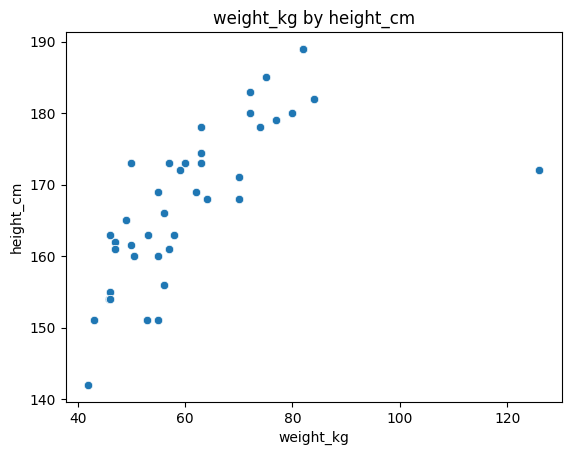

In [83]:
fig = visualize_two_cols('weight_kg', 'height_cm')

#### 2.  A histogram / density plot of a numeric column stratified by a categorical column

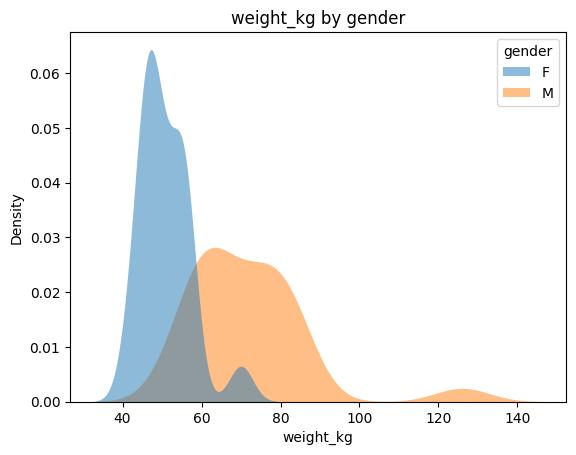

In [84]:
fig = visualize_two_cols_cn('gender', 'weight_kg')

#### 3. A stacked bar plot of two categorical columns

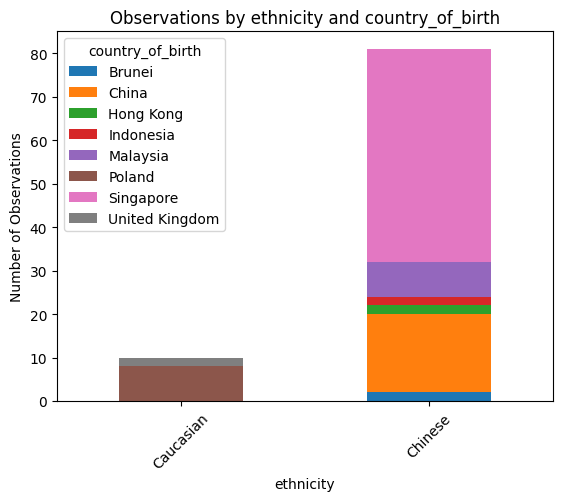

In [85]:
fig = visualize_two_cols_cc('ethnicity', 'country_of_birth')